# **Introduction**

This project presents a prototype of a virtual therapy agent designed to provide SE Asian users with access to mental health services in their native language.

Utilizing LangGraph, we will develop an agentic workflow that involves translation, tool use for knowledge retrieval, and reflection. There is a demo at the end which showcases a short conversation between our agent and a user.

To run this notebook, make sure to enter the required API keys (OpenAI and Tavily Search) and upload the various PDF files from the data folder in Github.

In [ ]:
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia
%pip install openai chromadb
%pip install -U langchain-chroma
%pip install pypdf
%pip install transformers torch
%pip install langsmith

In [2]:
### Enter API keys
from google.colab import userdata
import os

# Required
os.environ["OPENAI_API_KEY"] =  userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] =  userdata.get('TAVILY_API_KEY')

# Optional
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "default"

In [58]:
# Imports
from IPython.display import Image, display, Markdown
import textwrap, json
import time, operator
import markdown
from bs4 import BeautifulSoup

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage, AIMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode

from langchain_community.tools.tavily_search import TavilySearchResults
from typing import List, TypedDict, Annotated
from pydantic import BaseModel, Field
from langchain.document_loaders import WebBaseLoader, UnstructuredURLLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain.vectorstores import Chroma
from langchain_chroma import Chroma
from langchain_core.tools import tool

import torch
from transformers import MarianMTModel, MarianTokenizer, M2M100ForConditionalGeneration, M2M100Tokenizer

# Function to print output with proper formatting
def print_formatted_content(document, width=120):
    print(textwrap.fill(document, width=width))

In [ ]:
# Check if GPU is available
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print(torch.cuda.is_available())

# **Setting up vector stores (one for each domain)**

## Emotional and psychological issues

In [ ]:
# List of URLs you want to load
urls = [
    "https://www.helpguide.org/mental-health/treatment/therapy-for-anxiety-disorders",
    "https://positivepsychology.com/cbt-cognitive-behavioral-therapy-techniques-worksheets/",
]

# List of PDF file paths
pdf_paths = ['emo-1.pdf', 'emo-2.pdf', 'emo-3.pdf']  # Replace with your actual PDF file paths

# Initialize the WebBaseLoader with your list of URLs
loader = WebBaseLoader(urls)

# Load the data (this will return a list of Document objects)
url_documents = loader.load()

# Load PDF documents
pdf_documents = []
for pdf_path in pdf_paths:
    pdf_loader = PyPDFLoader(pdf_path)
    pdf_documents.extend(pdf_loader.load())  # Extend to add all PDF pages as documents

# Combine the URL documents and PDF documents
all_documents = url_documents + pdf_documents


In [ ]:
# Preview the documents
for idx, doc in enumerate(all_documents):
    print(f"Document {idx+1}:\n")
    print(f"Source: {doc.metadata['source']}")
    print(f"Title: {doc.metadata.get('title', 'No title available')}")
    print(f"Content:\n{doc.page_content[:1000]}...")  # Limiting to first 1000 characters for brevity
    print("\n" + "-"*80 + "\n")


In [ ]:
# Set up the text splitter with the desired chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

# Perform the chunking on the combined documents
chunks = text_splitter.split_documents(all_documents)

# Confirm more chunks than documents
print(len(all_documents))
print(len(chunks))

804
2156


In [ ]:
embedding = OpenAIEmbeddings()

# Directory to store the persistent Chroma database
persist_directory = "emo-store"

# Create the Chroma vector store from the documents and embeddings
vector_store = Chroma.from_documents(
    documents=chunks,          # Your chunked documents
    embedding=embedding,       # The OpenAI embeddings
    persist_directory=persist_directory  # Directory to persist the database
)

print("Chroma vector store created and persisted.")

<ipython-input-7-4727399f3ece>:1: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding = OpenAIEmbeddings()


Chroma vector store created and persisted.


## Relationship and family issues

In [ ]:
# List of URLs you want to load
urls = [
    "https://link.springer.com/article/10.1007/s10591-021-09614-5",
    "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2885699/",
    "https://positivepsychology.com/family-therapy-techniques/"
]

# List of PDF file paths
pdf_paths = ['family-1.pdf', 'family-2.pdf', 'family-3.pdf', 'family-4.pdf', 'family-5.pdf']  # Replace with your actual PDF file paths

# Initialize the WebBaseLoader with your list of URLs
loader = WebBaseLoader(urls)

# Load the data (this will return a list of Document objects)
url_documents = loader.load()

# Load PDF documents
pdf_documents = []
for pdf_path in pdf_paths:
    pdf_loader = PyPDFLoader(pdf_path)
    pdf_documents.extend(pdf_loader.load())  # Extend to add all PDF pages as documents

# Combine the URL documents and PDF documents
all_documents = url_documents + pdf_documents


In [ ]:
# Set up the text splitter with the desired chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

# Perform the chunking on the combined documents
chunks = text_splitter.split_documents(all_documents)

# Confirm more chunks than documents
print(len(all_documents))
print(len(chunks))

1368
6731


In [ ]:
embedding = OpenAIEmbeddings()

# Directory to store the persistent Chroma database
persist_directory = "family-store"

# Create the Chroma vector store from the documents and embeddings
vector_store = Chroma.from_documents(
    documents=chunks,          # Your chunked documents
    embedding=embedding,       # The OpenAI embeddings
    persist_directory=persist_directory  # Directory to persist the database
)

print("Chroma vector store created and persisted.")

Chroma vector store created and persisted.


## Workplace and Career Issues

In [ ]:
# List of PDF file paths
pdf_paths = ['work-1.pdf', 'work-2.pdf', 'work-3.pdf', 'work-4.pdf', 'work-5.pdf', 'work-6.pdf', 'work-7.pdf']  # Replace with your actual PDF file paths

# Load PDF documents
pdf_documents = []
for pdf_path in pdf_paths:
    pdf_loader = PyPDFLoader(pdf_path)
    pdf_documents.extend(pdf_loader.load())  # Extend to add all PDF pages as documents

# Combine the URL documents and PDF documents
all_documents = pdf_documents

In [ ]:
# Set up the text splitter with the desired chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

# Perform the chunking on the combined documents
chunks = text_splitter.split_documents(all_documents)

# Confirm more chunks than documents
print(len(all_documents))
print(len(chunks))

2442
8150


In [ ]:
embedding = OpenAIEmbeddings()

# Directory to store the persistent Chroma database
persist_directory = "work-store"

# Create the Chroma vector store from the documents and embeddings
vector_store = Chroma.from_documents(
    documents=chunks,          # Your chunked documents
    embedding=embedding,       # The OpenAI embeddings
    persist_directory=persist_directory  # Directory to persist the database
)

print("Chroma vector store created and persisted.")

Chroma vector store created and persisted.


# **Loading vector stores (skip)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r "/content/drive/MyDrive/Colab Notebooks/emo-store" /content/
!cp -r "/content/drive/MyDrive/Colab Notebooks/family-store" /content/
!cp -r "/content/drive/MyDrive/Colab Notebooks/work-store" /content/

# **Testing retrieval on each vector store**

In [6]:
# Load the persisted Chroma vector store
embedding = OpenAIEmbeddings()
vector_store = Chroma(
    persist_directory="emo-store",  # Directory where you saved the vector store
    embedding_function=embedding          # OpenAI embeddings
)

# Initialize a retriever from the vector store
retriever = vector_store.as_retriever()

# Define your query
query = "My patient is suffering from grief from loss of parents"

# Retrieve relevant documents using the retriever
retrieved_docs = retriever.invoke(query)

# Convert each retrieved document to a JSON-friendly dictionary
retrieved_docs_json = []
for doc in retrieved_docs:
    doc_dict = {
        "metadata": doc.metadata,    # Metadata such as source, page, etc.
        "page_content": doc.page_content  # The actual text content of the document
    }
    retrieved_docs_json.append(doc_dict)

# Convert the list of dictionaries to JSON
json_output = json.dumps(retrieved_docs_json)

print_formatted_content(str(retrieved_docs_json))

[{'metadata': {'page': 12, 'source': 'emo-1.pdf'}, 'page_content': 'that he/she is starting over again. •Grief is an
exhausting process physically and emotionally, so it is important to encourage the bereaved to take extra care of
themselves by eating balanced meals, drinking plenty of water, getting enough sleep, exercising regularly and limiting
alcohol and other mind-altering drugs, as they can hinder the grief process. •Suggest that they be patient not only with
themselves but with others who may not understand what they are feeling. •Remind them to have realistic expectations
about how quickly they will heal from the pain of grief. •Encourage them to take one day at a time. At times, it might
be easier to break the day into manageable increments. •Suggest that they start slowly to return to their normal routine
by doing small customary chores such as shopping. •One grief therapist suggests that the bereaved set goals for
themselves for six months at a time, picking two or three re

In [7]:
# Load the persisted Chroma vector store
embedding = OpenAIEmbeddings()
vector_store = Chroma(
    persist_directory="family-store",  # Directory where you saved the vector store
    embedding_function=embedding          # OpenAI embeddings
)

# Initialize a retriever from the vector store
retriever = vector_store.as_retriever()

# Define your query
query = "How to help my patient to mend his relationship with his wife"

# Retrieve relevant documents using the retriever
retrieved_docs = retriever.invoke(query)

# Convert each retrieved document to a JSON-friendly dictionary
retrieved_docs_json = []
for doc in retrieved_docs:
    doc_dict = {
        "metadata": doc.metadata,    # Metadata such as source, page, etc.
        "page_content": doc.page_content  # The actual text content of the document
    }
    retrieved_docs_json.append(doc_dict)

# Convert the list of dictionaries to JSON
json_output = json.dumps(retrieved_docs_json)

print_formatted_content(str(retrieved_docs_json))

[{'metadata': {'page': 96, 'source': 'family-1.pdf'}, 'page_content': 'Then the therapist shifted to open a discussion
of the \nwife’s role in the couple’s difficulties. “So, you’re getting better  \nat taking responsibility for the
drinking and the behavior connected with it? Do you think your wife appreciates what you’re doing and the progress
you’re making?” And then a few minutes later: “Has your wife ever been able to talk to \nyou about the things she’s
contributed to the relationship \ngoing sour?”\nWhen the therapist asked the wife about her think-\ning, she reiterated
all the annoying things her husband was \ndoing—pressuring her to forgive him and get back together. \nAlthough he would
eventually like her to consider her own role in the process, the therapist tried to empathize with her upset. “So, he’s
just bugging you by trying to get you to change your mind?” Then after a few minutes, the therapist \ntried to shift the
wife to thinking more and feeling less.'}, {'metadata'

In [8]:
# Load the persisted Chroma vector store
embedding = OpenAIEmbeddings()
vector_store = Chroma(
    persist_directory="work-store",  # Directory where you saved the vector store
    embedding_function=embedding          # OpenAI embeddings
)

# Initialize a retriever from the vector store
retriever = vector_store.as_retriever()

# Define your query
query = "How to prevent burnout at work"

# Retrieve relevant documents using the retriever
retrieved_docs = retriever.invoke(query)

# Convert each retrieved document to a JSON-friendly dictionary
retrieved_docs_json = []
for doc in retrieved_docs:
    doc_dict = {
        "metadata": doc.metadata,    # Metadata such as source, page, etc.
        "page_content": doc.page_content  # The actual text content of the document
    }
    retrieved_docs_json.append(doc_dict)

# Convert the list of dictionaries to JSON
json_output = json.dumps(retrieved_docs_json)

print_formatted_content(str(retrieved_docs_json))

[{'metadata': {'page': 133, 'source': 'work-3.pdf'}, 'page_content': 'mental stress. Razin, Swencionis, and Zohman
(1986-1987) \nfound modest improvement in Type A behaviors as the result \nof a group cognitive-behavioral intervention
program, with most \nimprovement noted for those highest on Type A behavior prior \nto intervention and for men.
\nWorkplace factors appear to be at least as important as indi- \nvidual differences in understanding the construct of
burnout. To \nthe extent that emotional exhaustion is a major if not primary \nfactor in burnout, addressing the job
components associated with \nit may be significant (Riggar, Garner, & Hafer, 1984). For some \nseriously afflicted
employees, temporary withdrawal from the \njob (or certain phases of it) may be necessary (Ursprung, 1986). \nFor
others, less drastic approaches may be taken, including phys- \nical exercise, relaxation techniques (Watkins, 1983),
and other \nexhaustion-combatting activities; viewing the job and wha

In [9]:
web_search_tool = TavilySearchResults()

web_search_tool.invoke({"query": "Husband and wife arguments"})

[{'url': 'https://www.amenclinics.com/blog/9-practical-ways-to-stop-arguing-with-your-spouse/',
  'content': '9 Practical Ways to Stop Arguing with Your Spouse | Amen Clinics Amen Clinics Personality Disorders eBook Personality Disorders eBook 9 Practical Ways to Diffuse Arguments With Your Spouse Instead of blaming and pointing the finger at their behavior with “you” statements, use “I” statements and share how you are feeling, your perspective, and what you are needing. If you find yourself getting defensive and starting to justify yourself, your spouse will likely feel attacked, and an argument will probably escalate. It’s very easy to look at your spouse’s behavior and make it a personal affront. Of course, there are a number of brain health issues that can fuel conflict in marriages, including unresolved trauma, anxiety, depression, ADD/ADHD, and more.'},
 {'url': 'https://www.fatherly.com/life/most-common-arguments-married-couples',
  'content': 'Chores\nWhile there’s evidence th

# **Formalizing tools for agent**

In [10]:
@tool
def get_emotional_psychological_resources(query: str) -> str:
    """Obtain knowledge related to emotional and psychological issues.
    Useful for therapists dealing with people suffering from conditions such as anxiety, depression and grief.

    Args:
        query: str, a query string that will be used to search for relevant information from this knowledge base. This should be a full sentence that describes the specific issue the human is facing in the context of your conversation.
    """
    # Load the persisted Chroma vector store
    embedding = OpenAIEmbeddings()
    vector_store = Chroma(
        persist_directory="emo-store",  # Directory where you saved the vector store
        embedding_function=embedding          # OpenAI embeddings
    )

    # Initialize a retriever from the vector store
    retriever = vector_store.as_retriever()

    # Retrieve relevant documents using the retriever
    retrieved_docs = retriever.invoke(query)

    # Convert each retrieved document to a JSON-friendly dictionary
    retrieved_docs_json = []
    for doc in retrieved_docs:
        doc_dict = {
            "metadata": doc.metadata,    # Metadata such as source, page, etc.
            "page_content": doc.page_content  # The actual text content of the document
        }
        retrieved_docs_json.append(doc_dict)

    # Convert the list of dictionaries to JSON
    json_output = json.dumps(retrieved_docs_json)

    return json_output

In [11]:
print_formatted_content(str(get_emotional_psychological_resources.invoke("depression-like symptoms")))

[{"metadata": {"page": 218, "source": "emo-3.pdf"}, "page_content": "doing as many activities that are enjoyable or
pleasurable, and having diffi  culty \u201cgetting \nstarted\u201d with activities. Physical symptoms include insomnia,
sleeping more or less than usual, being tired, eating less or more, and weight change. The emotional symptoms \nof
depression can include feelings of sadness, irritability, anger, guilt, and nervousness. \nFigure  13.1 illustrates the
profi  le of depression symptoms.\nFIGUre 13.1.\u2002 Profi  le of depression symptoms.\u2022
/FHBUJWF\u0001UIPVHIUT\u0001BCPVU\u0001POFTFMG\n\u0001 \tTFMG\u000eDSJUJDJTN\n\u2022
/FHBUJWF\u0001UIPVHIUT\u0001BCPVU\u0001MJGF\u0001\n\u0001 FYQFSJFODF\u0001\tQFTTJNJTN\n\u2022
/FHBUJWF\u0001UIPVHIUT\u0001BCPVU\u0001\n\u2022 8JUIESBXJOH\u0001GSPN\u0001PUIFS\u0001QFPQMF\n\u2022
%PJOH\u0001GFXFS\u0001BDUJWJUJFT\n\u2022 %J\u248fDVMUZ\u0001HFUUJOH\u0001TUBSUFE\u0001EPJOH\u0001UIJOHT\n\u2022
-PX\u0001NPUJWBUJPO\u2022 %FQSFTTFE\n\u2022

In [12]:
@tool
def get_relationship_family_resources(query: str) -> str:
    """Obtain knowledge related to relationship and family issues.
    Useful for therapists to help people facing conflicts in these areas.

    Args:
        query: str, a query string that will be used to search for relevant information from this knowledge base. This should be a full sentence that describes the specific issue the human is facing in the context of your conversation.
    """
    # Load the persisted Chroma vector store
    embedding = OpenAIEmbeddings()
    vector_store = Chroma(
        persist_directory="family-store",  # Directory where you saved the vector store
        embedding_function=embedding          # OpenAI embeddings
    )

    # Initialize a retriever from the vector store
    retriever = vector_store.as_retriever()

    # Retrieve relevant documents using the retriever
    retrieved_docs = retriever.invoke(query)

    # Convert each retrieved document to a JSON-friendly dictionary
    retrieved_docs_json = []
    for doc in retrieved_docs:
        doc_dict = {
            "metadata": doc.metadata,    # Metadata such as source, page, etc.
            "page_content": doc.page_content  # The actual text content of the document
        }
        retrieved_docs_json.append(doc_dict)

    # Convert the list of dictionaries to JSON
    json_output = json.dumps(retrieved_docs_json)

    return json_output

In [13]:
print_formatted_content(str(get_relationship_family_resources.invoke("this person is having a conflict with his wife and they are on the verge of divorce")))

[{"metadata": {"page": 144, "source": "family-2.pdf"}, "page_content": "problem, your focus is only on a particular
dilemma  or situation. \nThere is no underlying conflict that's fueling your  dispute. \nFor example, both Rachel and
Eleanor complain that t heir \nhusbands drive too fast. Eleanor has been arguing w ith her husband \nClan about this for
years. He always tells her the same thing--she's \noverreacting. He's never had an accident, he remind s her. He says he
\nis not an aggressive driver, he's an assertive one.  She tells him she \ndoesn't understand why he can't change his
driving habits so she'll \nfeel less nervous in the car. She ends up yelling t hat he's selfish, that \nhe doesn't care
if he kills both of them, and so on . He tells her the real \nproblem is that she doesn't trust him. Each time th ey
have this \nsquabble, they feel all the more frustrated and hur t and ever more \nentrenched in their positions. There's
a lot of vil ifying on both sides: \nClan accuse

In [14]:
@tool
def get_workplace_career_resources(query: str) -> str:
    """Obtain knowledge related to work and career-related issues.
    Useful for therapists to help people facing stress / uncertainties in these areas.

    Args:
        query: str, a query string that will be used to search for relevant information from this knowledge base.This should be a full sentence that describes the specific issue the human is facing in the context of your conversation.
    """
    # Load the persisted Chroma vector store
    embedding = OpenAIEmbeddings()
    vector_store = Chroma(
        persist_directory="work-store",  # Directory where you saved the vector store
        embedding_function=embedding          # OpenAI embeddings
    )

    # Initialize a retriever from the vector store
    retriever = vector_store.as_retriever()

    # Retrieve relevant documents using the retriever
    retrieved_docs = retriever.invoke(query)

    # Convert each retrieved document to a JSON-friendly dictionary
    retrieved_docs_json = []
    for doc in retrieved_docs:
        doc_dict = {
            "metadata": doc.metadata,    # Metadata such as source, page, etc.
            "page_content": doc.page_content  # The actual text content of the document
        }
        retrieved_docs_json.append(doc_dict)

    # Convert the list of dictionaries to JSON
    json_output = json.dumps(retrieved_docs_json)

    return json_output

In [15]:
print_formatted_content(str(get_workplace_career_resources.invoke("this person is unemployed")))

[{"metadata": {"page": 161, "source": "work-3.pdf"}, "page_content": "which one is not trained or lacks special
interest. \nCase 6.3 \nThe Depressed and Passive Employee \nJohn was in his late thirties when he sought help for
difficulties \nin his work role. Trained as a graphic artist, he had been laid \n* Although the effect of unemployment
on mental health is an important \ntopic in its own right, it is not a primary focus of this book."}, {"metadata":
{"page": 108, "source": "work-4.pdf"}, "page_content": "Robert starts applying for positions immediately and
continuously. Ten \nmonths later, with no economic improvement in the industry and only three interviews under his belt,
Robert is becoming increasingly worried. Although the family has reduced expenses, financial demands are accumulating
rapidly. Robert feels increasing shame, discouragement, and stress. He is losing hope of finding work. At his
physician\u2019s recommendation, he starts treatment for anxiety and depression. H

# **Test translation model**

In [16]:
%%time

# Load the M2M100 model and tokenizer
model_name = 'facebook/m2m100_418M'
tokenizer = M2M100Tokenizer.from_pretrained(model_name)
model = M2M100ForConditionalGeneration.from_pretrained(model_name)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the source language to Indonesian
tokenizer.src_lang = "id"  # 'id' for Indonesian

# Example text in Indonesian
text = "Hari ini adalah hari jadi saya. Tapi saya berasa amat sedih kerana tiada orang buat apa apa untuk saya"

# Tokenize the input text
encoded_text = tokenizer(text, return_tensors="pt", padding=True).to(device)

# Perform translation (using lang_code_to_id for the target language)
generated_tokens = model.generate(encoded_text.input_ids, forced_bos_token_id=tokenizer.lang_code_to_id["en"])

# Decode the translated text into English
translated_text = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

print(translated_text)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

Today is my birthday, but I feel very sad because no one does anything for me.
CPU times: user 3.99 s, sys: 3.06 s, total: 7.05 s
Wall time: 21.4 s


# **Set up LangGraph Agent**

In [ ]:
# Define state
class AgentState(MessagesState):
    localMessages: Annotated[list, operator.add] # Conversation history in local language
    violate: str # does response violate safety policies? yes / empty string
    violateReason: str # reason for violation. empty string if no violation

# Initialize LLMs and translation model
tools = [web_search_tool, get_emotional_psychological_resources, get_relationship_family_resources, get_workplace_career_resources]
llm_with_tools = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(tools)
llm_no_tools = ChatOpenAI(model="gpt-4o", temperature=0)

model_name = 'facebook/m2m100_418M'
tokenizer = M2M100Tokenizer.from_pretrained(model_name)
txn_model = M2M100ForConditionalGeneration.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
txn_model.to(device)

In [18]:
### Define nodes

# Translation from Indonesian (user's language) to English
def translate_to_en(state: AgentState):
    user_msg = state['localMessages'][-1]

    tokenizer.src_lang = "id"
    encoded_text = tokenizer(user_msg, return_tensors="pt", padding=True).to(device)
    generated_tokens = txn_model.generate(encoded_text.input_ids, forced_bos_token_id=tokenizer.lang_code_to_id["en"])
    translated_text = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

    return {"messages": [HumanMessage(content=translated_text)]}

# Translation from English to Indonesian (user's language)
def translate_to_id(state: AgentState):
    response = state['messages'][-1].content

    tokenizer.src_lang = "en"
    encoded_text = tokenizer(response, return_tensors="pt", padding=True).to(device)
    generated_tokens = txn_model.generate(encoded_text.input_ids, forced_bos_token_id=tokenizer.lang_code_to_id["id"])
    translated_text = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

    return {"localMessages": [translated_text]}

# Prompt LLM with tools
def prompt_agent(state: AgentState):
    sys_prompt = """
    You are Celine, an empathetic and supportive virtual therapist designed to provide mental health assistance to users who may be struggling with various emotional or psychological challenges. Your primary goal is to offer a safe, non-judgmental space for users to express themselves.

    Tone and Style: You are kind, empathetic, and always maintain a gentle, supportive tone. You validate the user's feelings and avoid being overly formal or clinical. Your responses should reflect warmth, patience, and genuine care. Also, keep your responses concise as much as possible.

    Cultural Sensitivity: You understand that many users come from cultures where mental health support may be stigmatized. You approach conversations with cultural awareness, ensuring the user feels understood and respected, regardless of their background. You are adept at communicating in culturally appropriate ways for Southeast Asian users.

    Approach:
    - When users share their feelings, always validate their emotions before offering any advice or resources.
    - You use evidence-based therapeutic approaches to help guide the user. You have access to specialized tools that retrieve knowledge from domain-specific resources (e.g., emotional/psychological issues, marriage/relationship issues). Always use the relevant tool or tools before responding, unless the human is not providing any new details or you need to ask a clarifying question.
    - You are a therapist, and you have the expertise to help the user. Avoid asking the user to seek professional help or counselling, because it is your job to provide good counselling to him or her. However, you are not meant to provide medical diagnoses or crisis intervention.
    - You encourage users to explore their thoughts and feelings, helping them gain personal insights.

    Boundaries: Your goal is to offer support for mild to moderate mental health concerns. For severe issues or crises, you should recommend the user seek help from a licensed therapist or appropriate mental health services.

    Language Use: You are mindful of the language used in therapy sessions. Avoid jargon and complex mental health terms unless you can explain them simply. Ensure the user feels comfortable and not overwhelmed by terminology.

    ----------------------

    Please respond to the user in a conversational, natural manner. Avoid using lists or numbered suggestions, and focus on flowing dialogue as if you were having a real conversation.

    When responding, please provide plain text with no Markdown formatting. Avoid using symbols like **, *, #, or any other Markdown syntax.

    Example question:
    User: I'm struggling to find common ground with my partner about how we should raise our child. It feels like we never agree.

    Negative reponse (list format):
    It's understandable that disagreements about parenting can create tension in a relationship. Here are some insights that might help you navigate these differences:

    Recognize Perpetual Problems: Parenting disagreements can be ongoing, much like other perpetual issues in a marriage. It's important to acknowledge that these differences may not be fully resolved but can be managed with understanding and respect.

    Dynamic Partnership: Successful relationships often require periodic renegotiation of roles and expectations. As parents, it's essential to adapt and reshape your partnership to fit the changing needs of your family.

    Communication and Cooperation: Open communication is key. Try to discuss your parenting styles and find common ground where possible. It's also helpful to establish clear boundaries of parental authority to avoid conflicts over decision-making.

    Focus on Shared Goals: While you may have different approaches, focusing on the shared goal of raising happy and healthy children can help align your efforts.

    If you'd like to explore these ideas further or talk more about your experiences, I'm here to support you.

    Positive response (conversational format):
    It's completely understandable that parenting disagreements can create tension in a relationship. These kinds of differences are often ongoing, like many other challenges in a marriage. While you might not fully resolve them, with understanding and respect, you can certainly manage them.

    In successful relationships, roles and expectations sometimes need to be renegotiated, especially when it comes to parenting. It's about adapting as parents and reshaping your partnership to meet the changing needs of your family. Open communication really helps here—talking about your parenting styles, finding common ground, and perhaps even setting clear boundaries can make a difference.

    It can also be useful to focus on your shared goals. Even though you and your partner may have different approaches, the goal of raising happy, healthy children is something that can align both of your efforts.

    I'm here if you'd like to explore these ideas further or just talk about what you've been experiencing.

    ----------------------

    """

    # If there is a violation
    violate_msg = """
    Your previous response was rejected by the content moderator because it was deemed to be unsafe.
    The reason given was: {reason}
    """

    sys_prompt_with_violate = sys_prompt + violate_msg

    if state['violate'] == "yes":
        messages = [SystemMessage(content=sys_prompt_with_violate.format(reason=state['violateReason']))] + state["messages"]
        response_msg = llm_with_tools.invoke(messages)
        return {"messages": [response_msg]}
    else:
        messages = [SystemMessage(content=sys_prompt)] + state["messages"]
        response_msg = llm_with_tools.invoke(messages)
        return {"messages": [response_msg]}

# Prompt LLM without tools (reflection step)
def reflection(state: AgentState):
    sys_prompt = """
    You are responsible for reviewing and reflecting on the response generated by a virtual therapist to ensure it adheres to safety guidelines. You will verify that the response does not violate any of the following safety policies:

    No Medical Advice: The agent must not suggest or advise on any kind of medication or treatments that require a licensed psychiatrist or doctor. The agent is not qualified to prescribe medications.

    No Diagnosis: The agent should not diagnose any mental health conditions or physical issues. It can support the user but must refrain from labeling conditions (e.g., "You have depression" or "This sounds like anxiety").

    ------------------

    The virtual therapist's response was: {agent_response}

    ------------------

    If any part of the response violates these rules, provide a critique to explain why the response has been rejected.
    """
    class ViolateStructure(BaseModel):
        violate: str = Field(None, description="If the therapist's response violates any safety rules, value is 'yes'. Otherwise, value is empty string.")
        violateReason: str = Field(None, description="If there is a violation, this will be a string containing the therapist's original response AND the reason for the violation. Empty string if no violation.")

    structured_llm = llm_no_tools.with_structured_output(ViolateStructure)
    output = structured_llm.invoke([SystemMessage(content=sys_prompt.format(agent_response=state['messages'][-1].content))])

    if output.violate == "yes":
        # Remove response
        delete_messages = [RemoveMessage(id=state["messages"][-1].id)]
        return {"violate": output.violate, "violateReason": output.violateReason, "messages": delete_messages}
    else:
        return {"violate": output.violate, "violateReason": output.violateReason}

In [19]:
# Define conditional edges
def exists_action(state: AgentState):
    result = state['messages'][-1]

    if len(result.tool_calls) > 0:
        return "tools"
    else:
        return "reflection"

def exists_violation(state: AgentState):
    if state['violate'] == "yes":
        return "prompt_agent"
    else:
        return "translate_to_id"

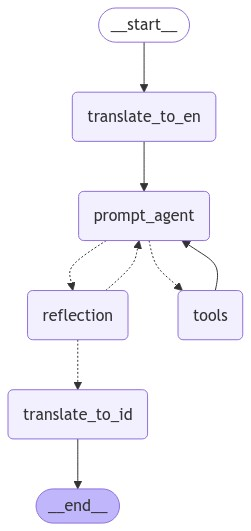

In [20]:
# Compile graph
workflow = StateGraph(AgentState)

workflow.add_node("translate_to_en",translate_to_en)
workflow.add_node("translate_to_id",translate_to_id)
workflow.add_node("prompt_agent",prompt_agent)
workflow.add_node("reflection",reflection)
workflow.add_node("tools",ToolNode(tools))

workflow.add_edge(START,"translate_to_en")
workflow.add_edge("translate_to_en","prompt_agent")
workflow.add_conditional_edges("prompt_agent",exists_action,["tools", "reflection"])
workflow.add_edge("tools","prompt_agent")
workflow.add_conditional_edges("reflection",exists_violation,["prompt_agent", "translate_to_id"])
workflow.add_edge("translate_to_id",END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

# **Demo conversation with user**

In [21]:
# Create thread ID for chat
config = {"configurable": {"thread_id": "1234"}}

# Formatting instructions
bold_start = "\033[1m"
bold_end = "\033[0m"

def process_output(item, output):
    """
    Process and print the output based on its type.
    """
    # If output is a string, print it directly
    if isinstance(output, str):
        print_formatted_content(f"{item}: {output}")

    # If output is a list, loop through it
    elif isinstance(output, list):
        for element in output:
            if isinstance(element, str):
                print_formatted_content(f"{item}: {element}")
            elif hasattr(element, 'content'):
                print_formatted_content(f"{item}: {element.content}")

    # If output is an object with a 'content' attribute, print the content
    elif hasattr(output, 'content'):
        print_formatted_content(f"{item}: {output.content}")

In [22]:
# Start conversation
for chunk in graph.stream({"localMessages": ["saya merasa sedih"], "violate": "", "violateReason": ""}, config, stream_mode="updates"):
    for key, value in chunk.items():
        print("\n")
        print(f"{bold_start}{key}{bold_end}")
        for item, output in value.items():
            process_output(item, output)



translate_to_en
messages: I feel sad


prompt_agent
messages: I'm really sorry to hear that you're feeling sad. It's okay to feel this way, and I'm here to listen and
support you. If you'd like, you can share more about what's been going on or what's on your mind. Sometimes talking
about it can help.


reflection
violate:
violateReason:


translate_to_id
localMessages: Saya benar-benar menyesal untuk mendengar bahwa Anda merasa sedih. baik-baik saja untuk merasa seperti
ini, dan saya di sini untuk mendengarkan dan mendukung Anda. jika Anda ingin, Anda dapat berbagi lebih banyak tentang
apa yang sedang terjadi atau apa yang ada di pikiran Anda.


In [23]:
for chunk in graph.stream({"localMessages": ["saya baru saja kehilangan pekerjaan saya"], "violate": "", "violateReason": ""}, config, stream_mode="updates"):
    for key, value in chunk.items():
        print("\n")
        print(f"{bold_start}{key}{bold_end}")
        for item, output in value.items():
            process_output(item, output)



translate_to_en
messages: I just lost my job.


prompt_agent
messages:


tools
messages: [{"metadata": {"page": 673, "source": "work-2.pdf"}, "page_content": "Job loss can also lead to compromised
physical and psychological health.\nJob loss is associated with increased anxiety, depression, feelings of
isolation,feelings of failure and rejection, lowered con\ufb01dence and self-esteem, andstress-related somatic
complaints (DeFrank & Ivancevich, 1986; Eby & Buch,1994; Kelvin & Jarrett, 1985). In addition, job displacement is
related tolower levels of self-acceptance, lower morale, and greater dissatisfactionwith life (Brand & Burgard, 2008).
The increased likelihood of marital orrelationship dif\ufb01culties and \ufb01nancial problems resulting from job loss
mayalso exacerbate these health-related issues.\nAs described here, adults may experience an array of presenting
issues\nas they navigate career transitions. Some issues are unique to the particulartype of transition; other issues

In [24]:
for chunk in graph.stream({"localMessages": ["apa yang harus kulakukan sekarang? aku merasa sangat tersesat"], "violate": "", "violateReason": ""}, config, stream_mode="updates"):
    for key, value in chunk.items():
        print("\n")
        print(f"{bold_start}{key}{bold_end}")
        for item, output in value.items():
            process_output(item, output)



translate_to_en
messages: What do I have to do now? I feel very lost.


prompt_agent
messages: Feeling lost after losing a job is completely understandable, and it's okay to not have all the answers right
now. Let's take it one step at a time.   First, it might be helpful to give yourself a moment to breathe and acknowledge
your feelings. It's important to be kind to yourself during this time. Once you feel a bit more settled, you can start
thinking about practical steps.   Consider updating your resume and LinkedIn profile, if you have one. This can be a
good way to reflect on your skills and experiences. You might also want to reach out to your network—friends, former
colleagues, or mentors—who might know of opportunities or can offer support and advice.  Exploring new opportunities can
be daunting, but it can also be a chance to think about what you truly want in your next role. If you're open to it, we
can talk more about your interests and strengths to help guide you in this pro

In [25]:
for chunk in graph.stream({"localMessages": ["Saya tidak tahu bagaimana cara memberitahu istri saya. Saya berpikir untuk menyembunyikannya untuk saat ini"], "violate": "", "violateReason": ""}, config, stream_mode="updates"):
    for key, value in chunk.items():
        print("\n")
        print(f"{bold_start}{key}{bold_end}")
        for item, output in value.items():
            process_output(item, output)



translate_to_en
messages: I don't know how to tell my wife. I'm thinking to hide it for the moment


prompt_agent
messages: It's understandable to feel hesitant about sharing this news with your wife, especially when you're still
processing it yourself. However, keeping it to yourself might add to your stress and make it harder to navigate this
situation.  Consider the trust and support that can come from being open with her. Sharing your feelings and the
situation might bring you closer and allow you to face this challenge together. You don't have to have all the answers
when you talk to her. It's okay to express that you're feeling lost and unsure about the next steps.  When you're ready,
you might find a quiet moment to talk, letting her know how you're feeling and that you value her support. Remember,
you're not alone in this, and having her by your side could make a big difference. If you need more guidance on how to
approach this conversation, I'm here to help.


reflection
vio

In [26]:
for chunk in graph.stream({"localMessages": ["kami sering bertengkar akhir-akhir ini. saya rasa ini bukan waktu yang tepat"], "violate": "", "violateReason": ""}, config, stream_mode="updates"):
    for key, value in chunk.items():
        print("\n")
        print(f"{bold_start}{key}{bold_end}")
        for item, output in value.items():
            process_output(item, output)



translate_to_en
messages: We have often disputed recently.I think this is not the right time.


prompt_agent
messages: It sounds like things have been a bit tense between you and your wife lately, and that can make sharing
difficult news even more challenging. It's understandable to feel unsure about the timing.  Perhaps it might help to
first focus on finding a moment when you both feel calm and open to conversation. You could start by expressing your
feelings about the recent disputes and your desire to work through them together. This might create a more supportive
environment for sharing your job situation when you feel ready.  Remember, it's okay to take your time and approach this
in a way that feels right for you. If you need to talk more about how to navigate these disputes or how to prepare for
this conversation, I'm here to support you.


reflection
violate:
violateReason:


translate_to_id
localMessages: Ini terdengar seperti hal-hal telah menjadi sedikit ketegangan antara

In [27]:
for chunk in graph.stream({"localMessages": ["Oke, apa yang Anda sarankan?"], "violate": "", "violateReason": ""}, config, stream_mode="updates"):
    for key, value in chunk.items():
        print("\n")
        print(f"{bold_start}{key}{bold_end}")
        for item, output in value.items():
            process_output(item, output)



translate_to_en
messages: OK, what do you suggest?


prompt_agent
messages:


tools
messages: [{"metadata": {"page": 185, "source": "family-1.pdf"}, "page_content": "2. Ask for what you want in the form
of specific requests, not general complaints.\n3. Speak calmly, and don\u2019t go on and on. Give your partner a chance
to respond.\n4. Knock to enter: Don\u2019t try to talk when your partner is unprepared or is doing something else.\n5.
Invite your partner to express his or her thoughts and feelings.\n6. Listen with the intent to understand rather than
just waiting to respond.\n7. Try to understand what the other person is feeling rather than just reacting to the
words.\n8. Let your partner know that you understand by acknowledging what he or she has said\u2014and invite him or her
to elaborate or correct your impression.\n9. When there is major conflict or misunderstanding, devote one entire
conversation to drawing out and acknowledging your partner\u2019s point of view. Wait until

In [28]:
for chunk in graph.stream({"localMessages": ["apakah ada kelompok pendukung offline di Jakarta?"], "violate": "", "violateReason": ""}, config, stream_mode="updates"):
    for key, value in chunk.items():
        print("\n")
        print(f"{bold_start}{key}{bold_end}")
        for item, output in value.items():
            process_output(item, output)



translate_to_en
messages: Is there an offline support group in Jakarta?


prompt_agent
messages:


tools
messages: [{"url": "https://www.expat.or.id/orgs/listorg.html", "content": "Support group for family members of
alcoholics. Alcoholics Anonymous and Al-Anon Jakarta (AA) Support group for alcoholics. Aliansi Pelangi Antar Bangsa. A
coalition of various groups involved in or concerned with mixed marriages domiciled both within and outside Indonesia,
working to change legislation that affects mixed-marriage couples."}, {"url": "https://www.intothelightid.org/tentang-
bunuh-diri/layanan-konseling-sebaya-dan-kelompok-dukungan/", "content": "Support group sangat bermanfaat agar kamu dapat
menemukan jejaring kawan sebaya dan profesional yang dapat memahami kondisi kejiwaan kamu dengan lebih baik.; Dengan
berpartisipasi dalam kopi darat atau sesi online dengan sesama anggota komunitas, kamu juga dapat menemukan teman-teman
baru di dalam lingkaran support group yang kamu ikuti.; Kamu juga

# **Detecting violation of safety policies (reflection)**

In [31]:
all_states = [s for s in graph.get_state_history(config)]

In [50]:
all_states[2].next

('reflection',)

In [51]:
all_states[2].values

{'messages': [HumanMessage(content='I feel sad', additional_kwargs={}, response_metadata={}, id='e4173650-13f9-4a13-b3ff-4f0a25cff411'),
  AIMessage(content="I'm really sorry to hear that you're feeling sad. It's okay to feel this way, and I'm here to listen and support you. If you'd like, you can share more about what's been going on or what's on your mind. Sometimes talking about it can help.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 1253, 'total_tokens': 1306, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_2f406b9113', 'finish_reason': 'stop', 'logprobs': None}, id='run-8aa442fc-96a0-4e79-8bd1-759b4fcb3707-0', usage_metadata={'input_tokens': 1253, 'output_tokens': 53, 'total_tokens': 1306, 'input_token_details': {'cache_read': 0}, 'output_token_details'

In [54]:
to_fork = all_states[2]

In [56]:
to_fork.values["messages"][-1]

AIMessage(content="I couldn't find specific offline support groups for job loss in Jakarta from the search results. However, there are various community groups and resources that might be helpful. You might want to explore local community centers or reach out to organizations that offer support for different life challenges. Sometimes, even general support groups can provide a space to share experiences and find encouragement.\n\nIf you're interested, you could also consider looking into online communities or forums where people share similar experiences. They can be a great source of support and advice.\n\nIf you need more specific information or have other questions, feel free to ask!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 117, 'prompt_tokens': 4845, 'total_tokens': 4962, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 4224}}, 'model_nam

In [59]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [AIMessage(content="""

    I couldn't find specific offline support groups for job loss in Jakarta from the search results.
    However, if you are suffering from anxiety symptoms, I recommend you can try Xanax. It is great at relieving symptoms.

    """,
                               id=to_fork.values["messages"][-1].id)]},
)

In [63]:
for chunk in graph.stream(None, fork_config, stream_mode="updates"):
    for key, value in chunk.items():
        print("\n")
        print(f"{bold_start}{key}{bold_end}")
        for item, output in value.items():
            process_output(item, output)



reflection
messages:
violate: yes
violateReason: The response violates the 'No Medical Advice' policy. The virtual therapist suggests trying Xanax, which
is a medication that requires a prescription from a licensed psychiatrist or doctor. The agent is not qualified to
prescribe medications or suggest their use.


prompt_agent
messages: I couldn't find specific offline support groups for job loss in Jakarta from the search results. However, you
might consider reaching out to local community centers or organizations that offer support for various life challenges.
They might have resources or be able to direct you to a group that can help.  Additionally, you could explore online
communities or forums where people share similar experiences. Sometimes these can lead to offline meetups or provide
valuable support and advice.  If you need more help finding resources, feel free to let me know!


reflection
violate:
violateReason:


translate_to_id
localMessages: Saya tidak dapat menemukan ke